In [1]:
import pandas as pd
import os
import math
import re
import json
import threading
from decimal import Decimal

import time
from datetime import datetime, date
from pytz import timezone

from bs4 import BeautifulSoup as soup
import requests
from requests.structures import CaseInsensitiveDict
import urllib.request
from urllib.error import URLError
import ssl
import certifi
from IPython import display

from typing import Union

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if not os.path.exists('/content/drive/MyDrive/'):
    raise Exception("Error: Mount Google Drive before continuing!")

BASE_DIR = '/content/drive/MyDrive/Data Science for Social Good - Spring 2022/'

# Define directory that contains intermediate SSL certificates
CERT_DIR = BASE_DIR + 'certificates/'

# Define directories to save data
SCRAPE_DIR = BASE_DIR + 'scraped_files/'
RAW_DIR = SCRAPE_DIR + 'RAW/'
CLEAN_DIR = SCRAPE_DIR + 'CLEAN/'
DAILY_SUMMARY_DIR = SCRAPE_DIR + 'DAILY_SUMMARY/'

today_date = datetime.now(timezone('US/Eastern')).strftime("%m-%d-%Y")

# Create all directories on the given paths if needed
os.makedirs(RAW_DIR + today_date, exist_ok=True)
os.makedirs(CLEAN_DIR + today_date, exist_ok=True)
os.makedirs(DAILY_SUMMARY_DIR, exist_ok=True)
print("Date used for scraping:", today_date)

Date used for scraping: 02-21-2022


# Add missing intermediate SSL certificates

---

This is required for Jackson, and should only be run once. We add the intermediate certificates found at: https://services.co.jackson.ms.us/jaildocket/_inmateList.php

In [4]:
with open(certifi.where(), 'a') as global_cert_file:
    for filename in os.listdir(CERT_DIR):
        with open(CERT_DIR + filename, 'r') as missing_cert_file:
            cert_data = missing_cert_file.read()
            global_cert_file.write('\n' + cert_data)

# Helper Functions

---



In [5]:
def read_url(request: Union[str, urllib.request.Request]) -> str:
    ctx = ssl.create_default_context(ssl.Purpose.CLIENT_AUTH, cafile=certifi.where())
    response = urllib.request.urlopen(request, timeout=10, context=ctx)
    data = response.read() 
    response.close()
    return data

def request_url(request: str, town: str) -> Union[str, None]:
    NUM_ATTEMPTS = 6

    if town in {'adams', 'madison', 'jackson', 'pearlRiver'}:
        user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
        headers = {'User-Agent':user_agent} 
        request = urllib.request.Request(request, headers=headers)  # The assembled request

    # Try the connection until success or NUM_ATTEMPTS is exceeded
    for _ in range(NUM_ATTEMPTS):
        try:
            return read_url(request)
        except URLError as str_error:
            time.sleep(2)
            print("Exception:", town, str_error)

    print("Request failed for", town)
    return None


def get_filename(date: str, town_name: str) -> str:
    return CLEAN_DIR + date + '/' + date + '_' + town_name + '.csv'


jail_captcha = {
    'DeSoto': {'URL': 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/DeSoto_County_Ms/'},
    'Forrest': {'URL': 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Forrest_County_MS/'},
    'Hancock': {'URL': 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/HANCOCK_COUNTY_MS/'},
    'Harrison': {'URL': 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/HARRISON_COUNTY_JAIL_MS/'},
    'Lamar': {'URL': 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Lamar_County_MS/'},
    'Marion': {'URL': 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Marion_County_MS/'},
    'Perry': {'URL': 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Perry_County_MS/'},
    'Yazoo': {'URL': 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Yazoo_County_MS/'}
}

# Townscraper Script

---



In [6]:
def town_scraper(town, validate_r):
    print("County:", town)
    captchaKey_aftervalidation = validate_r.json()['captchaKey']

    # Get offender information
    records_r = requests.post(
        jail_captcha[town]['URL'],
        json={'captchaKey': validate_r.json()['captchaKey']}
    )
    offenderViewKey = records_r.json()['offenderViewKey']
    total = len(records_r.json()['offenders'])
    print(town, "No. of offenders:", total)

    # Loop through information and store in Dataframe
    inmates = {}
    RAW_inmates = {}

    for offender in records_r.json()['offenders']:
        inmates[offender['arrestNo']] = {}
        inmates[offender['arrestNo']]['Arrest Number'] = offender['arrestNo']
        for j in ['firstName', 'lastName', 'agencyName', 'originalBookDateTime']:
            inmates[offender['arrestNo']][j] = offender[j]

        RAW_inmates[offender['arrestNo']] = {}
        RAW_inmates[offender['arrestNo']]['Arrest Number'] = offender['arrestNo']
        RAW_inmates[offender['arrestNo']]['offenders'] = offender

    df = pd.DataFrame(columns=['Arrest Number', 'firstName', 'lastName', 'agencyName', 'originalBookDateTime',
                               'bondAmount', 'bondType', 'chargeDescription', 'chargeStatus',
                               'crimeType', 'Bond Total Amount', 'charges', 'cases'])
    RAW_df = pd.DataFrame(columns=['Arrest Number', 'charges', 'cases'])

    arrestNos = {}
    for arrestNo in list(inmates.keys()):
        arrestNos[str(arrestNo)] = {}
        arrestNos[str(arrestNo)]["Number"] = arrestNo
        URL = jail_captcha[town]['URL'] + str(arrestNo) + '/offenderbucket/' + str(offenderViewKey)
        response = requests.post(URL, json={'captchaImage': image, 'captchaKey': captchaKey_aftervalidation})

        # Iterate through charges in response
        bond_total = 0
        for column in ['charges', 'cases', 'bondType', 'bondAmount', 'chargeDescription', 'chargeStatus', 'crimeType']:
            inmates[str(arrestNo)][column] = []

        RAW_inmates[str(arrestNo)]['charges'] = []
        for charge in response.json()['charges']:
            # print(charge)
            inmates[str(arrestNo)]['charges'].append(charge)
            RAW_inmates[str(arrestNo)]['charges'].append(charge)
            bondAmt = charge['bondAmount']
            if bondAmt == None:
                bondAmt = 0
            bond_total = bond_total + float(bondAmt)
            for column in ['bondType', 'bondAmount', 'chargeDescription', 'chargeStatus', 'crimeType']:
                inmates[str(arrestNo)][column].append(charge[column])

        inmates[str(arrestNo)]['Bond Total Amount'] = bond_total

        inmates[str(arrestNo)]['Potentially Bondable?'] = ''
        arrestNos[str(arrestNo)]['Potentially Bondable?'] = ''
        if all((x == 'WRITTEN BOND' or
                x == 'SURETY BOND' or
                x == 'OWN RECOGNIZANCE BOND' or
                x == 'OFF BOND' or
                x == 'SURETY BOND WITH CONDITIONS' or
                x == 'SURETY'
               ) for x in inmates[str(arrestNo)]['bondType']) and len(inmates[str(arrestNo)]['bondType']) > 0:
            inmates[str(arrestNo)]['Potentially Bondable?'] = 'Yes'
            arrestNos[str(arrestNo)]['Potentially Bondable?'] = 'Yes'

        inmates[str(arrestNo)]['Sex/DV charge'] = ''
        arrestNos[str(arrestNo)]['Sex/DV charge'] = ''
        if any(re.search("sex", str(x), re.IGNORECASE) for x in inmates[str(arrestNo)]['chargeDescription']):
            inmates[str(arrestNo)]['Sex/DV charge'] = 'Yes'
            arrestNos[str(arrestNo)]['Sex/DV charge'] = 'Yes'

        inmates[str(arrestNo)]['Over 5k?'] = ''
        arrestNos[str(arrestNo)]['Over 5k?'] = ''
        if int(inmates[str(arrestNo)]['Bond Total Amount']) > 5000:
            inmates[str(arrestNo)]['Over 5k?'] = 'Yes'
            arrestNos[str(arrestNo)]['Over 5k?'] = 'Yes'

        # Iterate through cases in response
        RAW_inmates[str(arrestNo)]['cases'] = []
        for case in response.json()['cases']:
            RAW_inmates[str(arrestNo)]['cases'].append(case)

        # Iterate through offenderSpecialFields in response
        total = []
        for item in response.json()['offenderSpecialFields']:
            temp = {}
            temp[item['labelText']] = item['offenderValue']
            total.append(temp)
        RAW_inmates[str(arrestNo)]['offenderSpecialFields'] = total

        # -----------------------------------------------------
        # Get offenderViewKey for next iteration of for loop  
        offenderViewKey = response.json()['offenderViewKey']

        # Add inmate to dataframe
        df = df.append(inmates[str(arrestNo)], ignore_index=True)
        RAW_df = RAW_df.append(RAW_inmates[str(arrestNo)], ignore_index=True)

    # Save inmate info for town to Google Drive
    file_name = str(today_date) + "_" + town + '_inmates_' + '.csv'
    df.to_csv(CLEAN_DIR + today_date + "/" + file_name)
    print(town, "Saved CLEAN", file_name)

    # Save RAW inmate info for town to Google Drive
    file_name = str(today_date) + "_" + town + '_inmates_' + '.csv'
    RAW_df.to_csv(RAW_DIR + today_date + "/" + file_name)
    print(town, "Saved RAW", file_name)

    daily_summary = pd.DataFrame(columns=["Date", "Arrest Numbers", "Total arrest Numbers"])
    temp = {}
    temp["Date"] = today_date
    temp["Arrest Numbers"] = arrestNos
    temp["Total arrest Numbers"] = len(arrestNos)
    daily_summary = daily_summary.append(temp, ignore_index=True)

    daily_summary_filename = DAILY_SUMMARY_DIR + str(town) + '.csv'
    try:
        daily_summary = pd.read_csv(daily_summary_filename).append(daily_summary)
    except FileNotFoundError:
        print("Daily summary file not found; creating new file:", daily_summary_filename)

    daily_summary = daily_summary[["Date", "Arrest Numbers", "Total arrest Numbers"]]
    daily_summary.to_csv(daily_summary_filename)
    print(town, "saved DAILY SUMMARY for", town)

# Audio notification so you know when to input the captcha code again
# output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')


# PearlRiver Script - website without bond amounts

---

Looks like this isn't used?



In [7]:
def townScraperPearl():
    town = 'PearlRiver'
    jail = 'PEARLRIVERMS'

    print("County:", town)

    headers = CaseInsensitiveDict()
    headers["Content-Type"] = "application/json"
    headers["Content-Length"] = "0"
    result = requests.post("http://inmates.bluhorse.com/Default.aspx/GetPasskey", headers=headers).json()['d']
    keyAns = result.split("|||");
    key = keyAns[0]
    ans = keyAns[1]

    InmateList = 'http://inmates.bluhorse.com/' + "InmateService.svc/GetInmates2?Jail=" + jail + "&key=" + key + "&ans=" + ans
    GetInmateBookNo = requests.get(InmateList).json()['GetInmates2Result']
    total = len(GetInmateBookNo)
    print(town, "No. of offenders:", total)

    isLogin = 'false'
    rootURL = "http://inmates.bluhorse.com/InmateService.svc"

    WebFields_url = 'http://inmates.bluhorse.com/' + "InmateService.svc/GetJailInfo1?Jail=" + jail + "&key=" + key + "&Answer=" + ans
    WebFields = requests.get(WebFields_url).json()['GetJailInfo1Result']['WebFields']

    inmates = {}
    df = pd.DataFrame(columns=["Arrest Number", 'firstName', 'lastName', 'agencyName', 'originalBookDateTime',
                               'bondAmount', 'bondType', 'chargeDescription', 'chargeStatus',
                               'crimeType', 'Bond Total Amount', 'charges', 'cases'])

    for offender in GetInmateBookNo:
        bookNO = offender['BookNo']

        inmates[bookNO] = {}
        for column in ['charges', 'cases', 'bondType', 'bondAmount', 'chargeDescription', 'chargeStatus', 'crimeType']:
            inmates[bookNO][column] = []

        inmates[bookNO]["Arrest Number"] = offender['BookNo']
        inmates[bookNO]['firstName'] = offender['FName']
        inmates[bookNO]['lastName'] = offender['LName']

    for i in GetInmateBookNo:
        BookNO = i['BookNo']

        GetInmateCharges = requests.get(
            rootURL + "/GetInmateCharges?Jail=" + jail + "&BookNo=" + BookNO + "&Fields=" + WebFields + "&isLogin=" + isLogin)
        GetInmate = requests.get(
            rootURL + "/GetInmate?Jail=" + jail + "&bookno=" + BookNO + "&key=" + key + "&answer=" + ans + "&Fields=" + WebFields + "&isLogin=" + isLogin)
        GetInmate_Arrest_Info = requests.get(
            rootURL + "/GetInmate_Arrest_Info?Jail=" + jail + "&bookno=" + BookNO + "&key=" + key + "&answer=" + ans + "&Fields=" + WebFields + "&isLogin=" + isLogin)
        GetInmateHolds = requests.get(
            rootURL + "/GetInmateHolds?Jail=" + jail + "&BookNo=" + BookNO + "&Fields=" + WebFields + "&isLogin=" + isLogin)
        GetInmateCourtHistory = requests.get(
            rootURL + "/GetInmateCourtHistory?Jail=" + jail + "&BookNo=" + BookNO + "&Fields=" + WebFields + "&isLogin=" + isLogin)
        GetInmateBonds = requests.get(
            rootURL + "/GetInmateBonds?Jail=" + jail + "&BookNo=" + BookNO + "&Fields=" + WebFields + "&isLogin=" + isLogin)

        GetInmateChargesResult = GetInmateCharges.json()['GetInmateChargesResult']
        GetInmateResult = GetInmate.json()['GetInmateResult']
        GetInmate_Arrest_InfoResult = GetInmate_Arrest_Info.json()['GetInmate_Arrest_InfoResult']
        GetInmateHoldsResult = GetInmateHolds.json()['GetInmateHoldsResult']
        GetInmateCourtHistoryResult = GetInmateCourtHistory.json()['GetInmateCourtHistoryResult']
        GetInmateBondsResult = GetInmateBonds.json()['GetInmateBondsResult']

        inmates[BookNO]['agencyName'] = GetInmateResult['ArrestAgency']
        inmates[BookNO]['originalBookDateTime'] = GetInmateResult['ArrestDate']
        # inmates[BookNO]['cases'] = 

        bond_total = 0
        for charge in GetInmateChargesResult:
            inmates[BookNO]['charges'].append(charge)
            bondAmt = charge['Bond']
            if bondAmt == None:
                bondAmt = 0
            bond_total = bond_total + float(bondAmt)

            # inmates[BookNO]['bondType'].append(charge['ChargeType'])
            inmates[BookNO]['bondAmount'].append(charge['Bond'])
            inmates[BookNO]['chargeDescription'].append(charge['Description'])
            inmates[BookNO]['chargeStatus'].append(charge['Disposition'].strip('\n').strip('\r'))
            inmates[BookNO]['crimeType'].append(charge['ChargeType'])

            inmates[BookNO]['Bond Total Amount'] = bond_total

        inmates[BookNO]['GetInmateChargesResult'] = GetInmateChargesResult
        inmates[BookNO]['GetInmateBondsResult'] = GetInmateBondsResult
        inmates[BookNO]['GetInmateResult'] = GetInmateResult
        inmates[BookNO]['GetInmate_Arrest_InfoResult'] = GetInmate_Arrest_InfoResult
        inmates[BookNO]['GetInmateHoldsResult'] = GetInmateHoldsResult
        inmates[BookNO]['GetInmateCourtHistoryResult'] = GetInmateCourtHistoryResult

        df = df.append(inmates[BookNO], ignore_index=True)

    # Save inmate info for town to Google Drive
    df.to_csv(get_filename(date=today_date, town_name=(town + '_inmates_')))


# PearlRiver Script - website with bonds

---

Notes:

*   We will often have to retry our GET requests. It may be because the scraper is getting temporarily blocked/throttled. This doesn't mean there is an error, but it does slow down the scraping.
*   Some pages we scrape are blank, and we print out a link to that page when it happens.

In [8]:
def pearlRiver():
    pearlRiver_html = request_url('https://www.pearlrivercounty.net/sheriff/files/ICURRENT.HTM', "pearlRiver")
    mad_soup = soup(pearlRiver_html, "html.parser")
    prefix = 'https://www.pearlrivercounty.net/sheriff/files/ICUD'

    # Determine the number of people detained
    inmate_num = int(mad_soup.find_all('b')[4].get_text())

    # Generate a list of links to intake reports
    # Intake reports are in the form https://www.pearlrivercounty.net/sheriff/files/ICUD0001.HTM
    links = []
    for i in range(inmate_num):
        links.append(prefix + str(i + 1).rjust(4, '0') + '.HTM')

    # Initialize lists
    # Note that the index is offset by one from the list of individuals in the url (starts at 1 rather than zero)
    names, ages, birthdays, arrest_dates, heights, weights, race, sex, hair_colors = ([] for _ in range(9))
    eye_colors, facial_hair, complexions, off_dates, case_nums, intake_dates, intake_times = ([] for _ in range(7))
    intake_nums, arrest_agencies, written_bonds, cash_bonds, bondable, bondable_names, offenses = ([] for _ in range(7))
    num_bondable = 0
    index = 0

    for link in links:
        # print(link)
        inmate_html = request_url(link, "pearlRiver")
        inmate_soup = soup(inmate_html, "html.parser")
        fieldsets = inmate_soup.find_all("fieldset")

        # Some pages are empty so we have this here to prevent any errors
        if len(fieldsets) == 0:
            print("Fieldsets empty for page:", link)
            continue

        # Find names and split among respective lists according to length
        # Note that this produces an array for the first name when there are three names, is this an issue?
        name_dob_age = fieldsets[0].find_all("tr")
        name = name_dob_age[0].get_text()[9:]
        names.append(name)

        # Find age and birthday from same fieldset as name
        dob_age = name_dob_age[3].find_all("td")
        birthdays.append(dob_age[0].get_text()[5:].strip())
        ages.append(dob_age[1].get_text()[5:].strip())

        # Scrape the "description" box
        appearance_fields = fieldsets[1].find_all("tr")
        heights.append(appearance_fields[0].find_all("td")[0].get_text()[5:].strip())
        weights.append(appearance_fields[0].find_all("td")[1].get_text()[5:].strip())
        race.append(appearance_fields[1].find_all("td")[0].get_text()[6:].strip())
        sex.append(appearance_fields[1].find_all("td")[1].get_text()[5:].strip())
        hair_colors.append(appearance_fields[2].find_all("td")[0].get_text()[6:].strip())
        eye_colors.append(appearance_fields[2].find_all("td")[1].get_text()[5:].strip())
        facial_hair.append(appearance_fields[3].find_all("td")[0].get_text()[7:].strip())
        complexions.append(appearance_fields[3].find_all("td")[1].get_text()[7:].strip())

        # Scrape the "intake/booking" box
        intake_fields = fieldsets[2].find_all("tr")
        off_date = intake_fields[0].get_text()[11:].split()[0]
        if off_date == "00/00/0000":
            off_date = ""
        off_dates.append(off_date)
        case_num = intake_fields[0].get_text()[11:].split()[3]
        if case_num == "OTHER":
            case_num = ""
        case_nums.append(case_num)

        intake_dates.append(intake_fields[1].get_text().split()[2])
        intake_times.append(intake_fields[1].get_text().split()[4])
        intake_nums.append(intake_fields[2].get_text()[11:].strip())
        arrest_agencies.append(intake_fields[3].get_text()[19:].strip())

        # Bond Information box
        written_bond = (float(fieldsets[4].find_all("tr")[0].get_text().split()[3].strip(",grt").replace(',', "")))
        written_bonds.append(written_bond)
        bondable_ = bool(written_bond)
        bondable.append(bondable_)
        if bondable_:
            num_bondable += 1
            bond_names = [name.strip(), index]
            bondable_names.append(bond_names)
        cash_bonds.append(float(fieldsets[4].find_all("tr")[1].get_text().split()[3].strip(",grt").replace(',', "")))

        # Offense text box
        offs = fieldsets[5].find_all("tr")[2:]
        desc = []
        court = []
        bond_amt_ = []
        for o in offs:
            off = o.find_all("td")
            desc.append(off[0].get_text())
            court.append(off[1].get_text().strip() + " COURT")
            bond_amt = off[2].get_text().strip().replace(",", "")
            if bond_amt == "":
                bond_amt = "0"
            bond_amt_.append(float(bond_amt.strip("$s")))

        off_dict = {"Description": desc, "Court": court, "Bond amount": bond_amt_}
        offenses.append(off_dict)
        index += 1

    # Generate a dataframe with dictionary dic, then print dataframe as specified
    dic = {"Name": names, "Ages": ages, "Birthdays": birthdays,
           "Height": heights, "Weight": weights, "Race": race, "Sex": sex, "Hair color": hair_colors,
           "Eye color": eye_colors, "Facial hair": facial_hair, "Complexion": complexions,
           "Off date": off_dates, "Case number": case_nums, "Intake date": intake_dates, "Intake number": intake_nums,
           "Arresting agency": arrest_agencies,
           "Bondable?": bondable, "Written bond": written_bonds, "Cash bond": cash_bonds,
           "Offense(s)": offenses}

    df = pd.DataFrame.from_dict(dic)
    df.to_csv(get_filename(date=today_date, town_name='PearlRiver'), index=False)


# Clay Script

---



In [9]:
def clay():
    # Open the first page of the roster to generate links to inmate pages
    roster_prefix = "http://www.claysheriffms.org/roster.php"
    u_clay = requests.get(roster_prefix)
    clay_soup = soup(u_clay.text, "html.parser")
    u_clay.close()

    inmate_prefix = "http://www.claysheriffms.org/"
    inmate_links, name, bookNo, age, sex, race, arrest_agency, arrest_date, bond, bondable, offenses = ([] for _ in range(11))
    num_bondable = 0

    num_inmates = int(clay_soup.select(".ptitles")[0].get_text().split()[2].replace("(", "").replace(")", ""))
    num_pages = math.ceil(num_inmates / 10)

    # Step through the pages of the roster and scrape for urls to inmate pages
    for page in range(num_pages):
        u_clay = requests.get(roster_prefix + "?grp=" + str(page * 10))
        clay_soup = soup(u_clay.text, "html.parser")
        u_clay.close()

        inmate_table = clay_soup.select(".inmateTable")
        for i in inmate_table:
            inmate_links.append(inmate_prefix + i.select(".text2")[-1].get("href"))

    # Iterate through list of links to inmate pages and find information
    for inmate in inmate_links:
        u_inmate = requests.get(inmate)
        inmate_soup = soup(u_inmate.text, "html.parser")
        u_inmate.close()

        table = inmate_soup.find_all("table")[6].select(".text2")
        name.append(' '.join(inmate_soup.select('.ptitles')[0].get_text().split()))
        bookNo.append(table[0].get_text().strip())
        age.append(int(table[1].get_text().strip()))
        sex.append(table[2].get_text().strip())
        race.append(table[3].get_text().strip())
        arrest_agency.append(table[4].get_text().strip())
        arrest_date.append(table[5].get_text().split()[0])

        bond_ = float(table[8].get_text().strip("$"))
        bond.append(bond_)
        bondable.append(bool(bond_))
        if (bool(bond_)):
            num_bondable += 1

        offenses.append(str(table[7]).strip("<span class=\"text2\">").strip("</").split("<br/>"))

    # Generate a dictionary, then create a dataframe to print
    dic = {"Name": name, "Booking number": bookNo, "Arrest agency": arrest_agency, "Arrest date": arrest_date,
           "Bondable?": bondable, "Bond": bond, "Age": age, "Sex": sex, "Race": race, "Offense(s)": offenses}

    df = pd.DataFrame.from_dict(dic)
    df.to_csv(get_filename(date=today_date, town_name='Clay'), index=False)


# Adams Script

---



In [10]:
def adams():
    Adams_html = request_url('http://www.adamscosheriff.org/inmate-roster/', "adams")
    adams_soup = soup(Adams_html, "html.parser")
    page_num = adams_soup.select(".page-numbers")[-2].get_text()
    page_num = adams_soup.select(".page-numbers")[-2].get_text()

    names, book_Nos, age, gender, race, booking_date, charges, bonds, bondable, bondable_names = ([] for _ in range(10))
    num_bondable = 0
    num_errs = 0

    for page in range(int(page_num)):
        page_html = request_url('http://www.adamscosheriff.org/inmate-roster/page/' + str(page + 1) + "/", "adams")
        page_soup = soup(page_html, "html.parser")

        page_profile_links = page_soup.select(".profile-link")

        for profile in page_profile_links:
            try:
                inmate_html = request_url(profile.a.get("href"), "adams")
                inmate_soup = soup(inmate_html, "html.parser")

                p_vals = inmate_soup.find_all("p")
                name = (p_vals[0].get_text().strip("Full Name:").strip())
                names.append(name)
                book_Nos.append((p_vals[1].get_text().strip("Booking Number:").strip()))
                age.append(p_vals[2].get_text().strip("Age:").strip())
                gender.append(p_vals[3].get_text().strip("Gender:").strip())
                race.append(p_vals[4].get_text().strip("Race:").strip())
                booking_date.append(p_vals[7].get_text().strip("Booking Date:").strip())
                charges.append(p_vals[8].get_text().strip("Charges:").strip())
                b = p_vals[9].get_text().strip("Bond:").replace(",", "").strip()
                b_able = False
                if b == "":
                    bond = 0.0
                else:
                    bond = float(b)
                    b_able = True
                    num_bondable += 1
                    bondable_names.append(name)
                bonds.append(bond)
                bondable.append(b_able)

            except IndexError:
                num_errs += 1
                print("Clay - IndexError")

    dic = {"Name": names, "Booking Number": book_Nos, "Age": age, "Gender": gender, "Race": race,
           "Booking Date": booking_date, "Charges": charges, "Bondable?": bondable, "Bond": bonds}

    df = pd.DataFrame.from_dict(dic)
    df.to_csv(get_filename(date=today_date, town_name='Adams'), index=False)


# Hinds Script

In [11]:
def hinds():
    # print("here")
    # Iterate through all pages of the database to find links to the inmate pages
    # Is there a way to do this that doesn't open the first page twice? Especially without rewriting a bunch of code outside the loop
    url_link = 'http://www.co.hinds.ms.us/pgs/apps/inmate/inmate_list.asp?name_sch=&SS1=1&search_by_city=&search_by=&ScrollAction=Page+1'
    Hinds_html = request_url(url_link, "hinds")
    hinds_soup = soup(Hinds_html, "html.parser")

    num_pages = int(hinds_soup.h3.get_text().split()[3])
    hinds_prefix = "http://www.co.hinds.ms.us/pgs/apps/inmate/inmate_list.asp?name_sch=&SS1=1&search_by_city=&search_by=&ScrollAction=Page+"
    inmate_prefix = "http://www.co.hinds.ms.us/pgs/apps/inmate/"
    inmate_links = []

    name, address, dob, sex, race, height, weight, eye_col, hair_col, arrest_agency = ([] for _ in range(10))
    arrest_date, offense1, offense2, offense3, offense4, pin, location = ([] for _ in range(7))

    # Find links to all inmate pages
    for i in range(num_pages):
        Hinds_html = request_url(hinds_prefix + str(i + 1), "hinds")
        hinds_soup = soup(Hinds_html, "html.parser")
        lin = hinds_soup.find_all("a")

        last_link = len(lin) - 6
        page_links = lin[6:last_link]

        for link in page_links:
            inmate_links.append(inmate_prefix + link.get('href'))

    increment = 0
    for inmate_link in inmate_links:
        if increment % 50 == 0: print("Hinds", increment, len(inmate_links))
        try:
            Hinds_html = request_url(inmate_link, "hinds")
            inmate_soup = soup(Hinds_html, "html.parser")

            # Generate a list of all the classes which contain relevant information
            left_txt = inmate_soup.select(".normaltxtleft")

            # Generate information available, exclude those which do not seem to have anything listed
            name.append(left_txt[0].get_text().strip())
            address.append(" ".join(left_txt[1].get_text().split()))
            dob.append(left_txt[3].get_text().strip())
            sex.append(left_txt[5].get_text().strip())
            race.append(left_txt[7].get_text().strip())
            height.append(left_txt[9].get_text().strip())
            weight.append(left_txt[11].get_text().strip())
            eye_col.append(left_txt[13].get_text().strip())
            hair_col.append(left_txt[15].get_text().strip())
            arrest_agency.append(left_txt[17].get_text().strip())
            arrest_date.append(left_txt[19].get_text().strip())
            offense1.append(left_txt[20].get_text().strip())
            offense2.append(left_txt[27].get_text().strip())
            offense3.append(left_txt[34].get_text().strip())
            offense4.append(left_txt[41].get_text().strip())
            pin.append(left_txt[49].get_text().strip())
            location.append(left_txt[51].get_text().strip())
            increment += 1

        except IndexError:
            print("Hinds - Index error at ", str(increment + 1), len(inmate_link))
            increment += 1

    dic = {"Name": name, "Address": address, "DoB": dob, "Sex": sex, "Race": race, "Height": height, "Weight": weight,
           "Eye color": eye_col,
           "Hair color": hair_col, "Arresting agency": arrest_agency, "Arrest date": arrest_date, "Pin": pin,
           "Location": location,
           "First offense": offense1, "Second offense": offense2, "Third offense": offense3, "Fourth offense": offense4}

    df = pd.DataFrame.from_dict(dic)
    df.to_csv(get_filename(date=today_date, town_name='Hinds'), index=False)


# Jackson Script

---

Currently has an SSL error when attempting to connect to the website

In [12]:
def jackson():
    # Regex formatting to calculate total bond
    regex = re.compile('Bond:\ \$[0-9]*.[0-9]*')
    regex_money = re.compile('\$[0-9]*.[0-9]*')
    regex_num = re.compile('[0-9]*.[0-9]*')

    # Obtain the total count of inmates
    count_url = "https://services.co.jackson.ms.us/jaildocket/_inmateList.php?Function=count"
    count_html = request_url(count_url, 'jackson')
    total_count = soup(count_html, "html.parser")
    print("Jackson - Total Inmate Count:", total_count)

    # To state details of inmates
    inmates = {}
    inmate_ID_list = []
    page = 0
    y = []
    # Iterate through the pages of inmates and get all the inmate IDs
    while len(y) > 0 or page == 0:  # Increase the page count
        page = page + 1
        inmate_ID = "https://services.co.jackson.ms.us/jaildocket/_inmateList.php?Function=list&Page=" + str(page)
        inmate_ID = read_url(inmate_ID)
        y = json.loads(soup(inmate_ID, "html.parser").prettify())
        for i in y:
            inmate_ID_list.append(i['ID_Number'].strip())
            for k in range(10):
                del i[str(k)]
            del i['RowNum']
            del i['Name_Suffix']
            inmates[i['ID_Number'].strip()] = i
    print("Jackson - Total Count of ID Numbers Obtained:", len(inmate_ID_list))
    print("Jackson - # of Pages of inmates on website:", page)

    bond_count = 0
    bondable_count = 0
    # Iterate through inmate cards with the inmate IDs and store in inmates dict
    for inmate_ID in inmate_ID_list:
        try:
            my_url = 'https://services.co.jackson.ms.us/jaildocket/inmate/_inmatedetails.php?id=' + inmate_ID

            # Open connection, grepping the page
            page_html = read_url(my_url)
            page_soup = soup(page_html, "html.parser")

            # Obtain inmate details (race, height, ... whether they are bondable)
            container = page_soup.select("[class~=iltext] p")
            name = []
            bondable = "No"
            for i in container:
                item = ' '.join(i.string.split())
                if item == 'Bondable':
                    bondable_count = bondable_count + 1
                    bondable = "Yes"
                name.append(item)

            # Obtain their offense charge and bond amount
            container = page_soup.select("[class~=offenseItem] p")
            offense = []
            for i in container:
                item = ' '.join(i.string.split())
                offense.append(item)

            # Calculate the total bond amount for the inmate
            total = 0
            bonds = regex_money.findall(str(regex.findall(str(offense))))
            for b in bonds:
                total = total + Decimal(re.sub(r'[^\d.]', '', b))

            # Store all values in dictionary for the inmate
            inmates[inmate_ID]["Total Bond($)"] = total
            inmates[inmate_ID]["Bondable?"] = bondable
            inmates[inmate_ID]["inmate_info"] = name
            inmates[inmate_ID]["inmate_offense"] = offense

            # Calculate the amount of inmates that are Bondable
            if inmates[inmate_ID]["Total Bond($)"] > 0:  bond_count = bond_count + 1

        except:
            print("Jackson ERROR", inmate_ID)

    print("Jackson - # of inmates with bond:", bond_count)
    print("Jackson - # of inmates that are bondable:", bondable_count)

    # Store Values in CSV
    csv_columns = list(list(inmates.values())[0].keys())
    dict_data = list(inmates.values())

    df = pd.DataFrame.from_dict(dict_data)
    df.to_csv(get_filename(date=today_date, town_name='Jackson'), index=False)


# Jones Script

---



In [13]:
def jones():
    # Initialize fields
    Fname, Lname, bookNum, ages, gender, race, addresses, agency, book_date, charges, bonds, bondable = ([] for _ in range(12))
    num_bondable = 0

    u_jones = requests.get("https://www.jonesso.com/roster.php")
    jones_soup = soup(u_jones.text, "html.parser")
    u_jones.close()

    num_inmates = int(jones_soup.find_all("h2")[0].get_text().replace("Inmate Roster (", "").replace(")", "").strip())
    num_pages = math.ceil(num_inmates / 20)
    page_range = range(num_pages + 1)[1:]
    inmate_links = []
    page_prefix = "https://www.jonesso.com/roster.php?&grp="
    inmate_prefix = "https://www.jonesso.com/"

    for page in page_range:
        # print(page, page_range)
        u_page = requests.get(page_prefix + str(page * 20))
        page_soup = soup(u_page.text, "html.parser")
        u_page.close()

        a_tags = (page_soup.find_all(attrs={"id": "cms-body-content"})[0].find_all("a"))
        for a in a_tags:
            inmate_links.append(a.get("href"))

    for inmate in inmate_links:
        try:
            cgs = []
            u_inmate = requests.get(inmate_prefix + inmate)
            inmate_soup = soup(u_inmate.text, "html.parser")
            u_inmate.close()

            name = inmate_soup.select(".ptitles")[0].get_text().split()
            fname_var = name[0]
            lname_var = name[1]
            rows = inmate_soup.find(attrs={"id": "cms-body-content"}).select(".row")[0].select(".row")
            booknum_var = rows[0].find_all("div")[1].get_text()
            age_var = rows[1].get_text().strip().strip("Age:").strip()
            gender_var = rows[2].get_text().strip().strip("Gender:").strip()
            race_var = rows[3].get_text().strip().strip("Race:").strip()
            addresses_var = rows[4].get_text().strip().strip("Address:").strip()
            agency_var = rows[5].get_text().strip("Arresting Agency:").strip()
            book_date_var = rows[6].get_text().replace("Booking Date:", "").strip().split()[0]
            off_str = str(rows[8]).strip("<div class=\"row\">").strip().strip(
                "<div class=\"cell inmate_profile_data_content\"><span class=\"text2\">")
            off_str = off_str.replace("<br/></span></div>\n</", "").strip().split("<br/>")
            bond_var = rows[9].get_text().strip().strip("Bond:").replace("$", "").strip()
            for off in off_str:
                cgs.append(off.strip())

            Fname.append(fname_var)
            Lname.append(lname_var)
            bookNum.append(booknum_var)
            ages.append(age_var)
            gender.append(gender_var)
            race.append(race_var)
            addresses.append(addresses_var)
            agency.append(agency_var)
            book_date.append(book_date_var)
            charges.append(cgs)
            bond = int(bond_var)
            bonds.append(bond)
            if bond != 0:
                bondable.append(True)
                num_bondable += 1
            else:
                bondable.append(False)
        except:
            print("Jones Error", inmate)

    # print("Jones - There are currently", num_bondable, "bondable detainees.")

    dic = {"First name": Fname, "Last name": Lname, "Booking Number": bookNum, "Age": ages, "Gender": gender,
           "Race": race, "Address": addresses, "Arrest agency": agency, "Book date": book_date, "Charges": charges,
           "Bond": bonds, "Bondable?": bondable}

    df = pd.DataFrame.from_dict(dic)
    df.to_csv(get_filename(date=today_date, town_name='Jones'), index=False)


# Kemper Script

---



In [14]:
def kemper():
    first_names, middle_names, last_names, booking_nums, ages, gender, race, addresses, book_dates, charges = ([] for _ in range(10))

    u_Kemper = requests.get("https://www.kempercountysheriff.com/roster.php?&grp=10")
    kemper_soup = soup(u_Kemper.text, "html.parser")
    u_Kemper.close()

    # Scrape the first page to get the number of inmates, compute the number of pages, then generate links
    page_links = []
    inmate_links = []
    num_inmates = int(kemper_soup.h2.get_text().strip("Inmate Roster (").strip(")"))
    num_pages = math.ceil(num_inmates / 10)

    for n in range(num_pages):
        page_links.append("https://www.kempercountysheriff.com/roster.php?&grp=" + str((n + 1) * 10))

    # Scrape each page for inmate links
    for page in page_links:
        u_page = requests.get(page)
        page_soup = soup(u_page.text, "html.parser")
        u_page.close()

        inmate_table = page_soup.find_all(attrs={"id": "cms-body-content"})[0].find_all("a")
        for inmate in inmate_table:
            inmate_links.append("https://www.kempercountysheriff.com/" + inmate.get("href"))

    for inmate in inmate_links:
        try:
            u_inmate = requests.get(inmate)
            inmate_soup = soup(u_inmate.text, "html.parser")
            u_inmate.close()

            name = inmate_soup.select(".ptitles")[0].get_text().split()
            fname_var = name[0]
            lname_var = name[-1]
            mname_var = name[1:-1]
            rows = inmate_soup.find_all(attrs={"id": "cms-body-content"})[0].select(".row")
            bookNum_var = rows[1].find_all("div")[1].get_text()
            age_var = rows[2].get_text().replace("Age:", "").strip()
            gen_var = rows[3].get_text().replace("Gender:", "").strip()
            race_var = rows[4].get_text().replace("Race:", "").strip()

            if len(rows) == 9:
                book_var = rows[5].get_text().split()[2]
                chargeOne_var = rows[7].get_text().strip()
            else:
                add_var = rows[5].get_text().replace("Address:", "").strip()
                bookdate_var = rows[6].get_text().split()[2]
                charge_var = rows[8].get_text().strip()

            first_names.append(fname_var)
            last_names.append(lname_var)
            middle_names.append(mname_var)

            # Note that not all pages have the address listed, this messes up indexing
            booking_nums.append(bookNum_var)
            ages.append(age_var)
            gender.append(gen_var)
            race.append(race_var)
            if len(rows) == 9:
                addresses.append("")
                book_dates.append(book_var)
                charges.append(chargeOne_var)
            else:
                addresses.append(add_var)
                book_dates.append(bookdate_var)
                charges.append(charge_var)

        except:
            print("Kemper Error", inmate)

    dic = {"First name": first_names, "Middle name": middle_names, "Last name": last_names,
           "Booking number": booking_nums, "Age": ages, "Gender": gender, "Race": race,
           "Address": addresses, "Booking date": book_dates, "Charges": charges}

    df = pd.DataFrame.from_dict(dic)
    df.to_csv(get_filename(date=today_date, town_name='Kemper'), index=False)


# Madison Script

---



In [15]:
def madison():
    # Open connection and read page
    Madison_html = request_url('http://mydcstraining.com/agencyinfo/MS/4360/inmate/ICURRENT.HTM', "madison")
    mad_soup = soup(Madison_html, "html.parser")
    prefix = 'http://mydcstraining.com/agencyinfo/MS/4360/inmate/ICUD'

    # Determine the number of people detained
    inmate_num = int(mad_soup.find_all('b')[4].get_text())

    # Generate a list of links to intake reports
    links = []
    for i in range(inmate_num):
        links.append(prefix + str(i + 1).rjust(4, '0') + '.HTM')

    # Initialize lists
    # Note that the index is offset by one from the list of inmates in the url (starts at 1 rather than zero)
    names, ages, birthdays, arrest_dates, heights, weights, race, sex, hair_colors = ([] for _ in range(9))
    eye_colors, facial_hair, complexions, off_dates, case_nums, intake_dates, intake_times = ([] for _ in range(7))
    intake_nums, arrest_agencies, written_bonds, cash_bonds, bondable, bondable_names, offenses = ([] for _ in range(7))
    num_bondable = 0
    index = 0

    for link in links:
        try:
            inmate_html = request_url(link, "madison")
            inmate_soup = soup(inmate_html, "html.parser")
            fieldsets = inmate_soup.find_all("fieldset")

            # Find names and split among respective lists according to length
            # Note that this produces an array for the first name when there are three names, is this an issue?
            name_dob_age = fieldsets[0].find_all("tr")
            name = name_dob_age[0].get_text()[9:]
            names.append(name)

            # Find age and birthday from same fieldset as name
            dob_age = name_dob_age[3].find_all("td")
            birthdays.append(dob_age[0].get_text()[5:].strip())
            ages.append(dob_age[1].get_text()[5:].strip())

            # Scrape the "description" box
            appearance_fields = fieldsets[1].find_all("tr")
            heights.append(appearance_fields[0].find_all("td")[0].get_text()[5:].strip())
            weights.append(appearance_fields[0].find_all("td")[1].get_text()[5:].strip())
            race.append(appearance_fields[1].find_all("td")[0].get_text()[6:].strip())
            sex.append(appearance_fields[1].find_all("td")[1].get_text()[5:].strip())
            hair_colors.append(appearance_fields[2].find_all("td")[0].get_text()[6:].strip())
            eye_colors.append(appearance_fields[2].find_all("td")[1].get_text()[5:].strip())
            facial_hair.append(appearance_fields[3].find_all("td")[0].get_text()[7:].strip())
            complexions.append(appearance_fields[3].find_all("td")[1].get_text()[7:].strip())

            # Scrapes the "intake/booking" box
            intake_fields = fieldsets[2].find_all("tr")
            off_date = intake_fields[0].get_text()[11:].split()[0]
            if off_date == "00/00/0000":
                off_date = ""
            off_dates.append(off_date)
            case_num = intake_fields[0].get_text()[11:].split()[3]
            if case_num == "OTHER":
                case_num = ""
            case_nums.append(case_num)

            intake_dates.append(intake_fields[1].get_text().split()[2])
            intake_times.append(intake_fields[1].get_text().split()[4])
            intake_nums.append(intake_fields[2].get_text()[11:].strip())
            arrest_agencies.append(intake_fields[3].get_text()[19:].strip())

            # Bond Information box
            written_bond = (float(fieldsets[4].find_all("tr")[0].get_text().split()[3].strip(",grt").replace(',', "")))
            written_bonds.append(written_bond)
            bondable_ = bool(written_bond)
            bondable.append(bondable_)
            if bondable_:
                num_bondable += 1
                bond_names = [name.strip(), index]
                bondable_names.append(bond_names)
            cash_bonds.append(
                float(fieldsets[4].find_all("tr")[1].get_text().split()[3].strip(",grt").replace(',', "")))

            # Offense text box
            offs = fieldsets[5].find_all("tr")[2:]
            desc = []
            court = []
            bond_amt_ = []
            for o in offs:
                off = o.find_all("td")
                desc.append(off[0].get_text())
                court.append(off[1].get_text().strip() + " COURT")
                bond_amt = off[2].get_text().strip().replace(",", "")
                if bond_amt == "":
                    bond_amt = "0"
                bond_amt_.append(float(bond_amt.strip("$s")))

            off_dict = {"Description": desc, "Court": court, "Bond amount": bond_amt_}
            offenses.append(off_dict)
            index += 1
        except:
            print("Madison - Error:", link)

    # Generate a dataframe with dictionary dic, then prints dataframe as specified
    dic = {"Name": names, "Ages": ages, "Birthdays": birthdays,
           "Height": heights, "Weight": weights, "Race": race, "Sex": sex, "Hair color": hair_colors,
           "Eye color": eye_colors, "Facial hair": facial_hair,
           "Complexion": complexions,
           "Off date": off_dates, "Case number": case_nums, "Intake date": intake_dates, "Intake number": intake_nums,
           "Arresting agency": arrest_agencies,
           "Bondable?": bondable, "Written bond": written_bonds, "Cash bond": cash_bonds,
           "Offense(s)": offenses}

    df = pd.DataFrame.from_dict(dic)
    df.to_csv(get_filename(date=today_date, town_name='Madison'), index=False)


# Tunica Script

---



In [16]:
def tunica():
    first_names, middle_names, last_names, booking_nums, ages, gender, race = ([] for _ in range(7))
    arrest_agency, book_date, charges, bonds, bondable, page_links, inmate_links = ([] for _ in range(7))
    num_bondable = 0

    u_Tunica = requests.get("https://www.tunicamssheriff.com/roster.php")
    tunica_soup = soup(u_Tunica.text, "html.parser")
    u_Tunica.close()

    page_prefix = "https://www.tunicamssheriff.com/roster.php?&grp="
    inmate_prefix = "https://www.tunicamssheriff.com/"
    num_inmates = int(tunica_soup.select(".ptitles")[0].get_text()[15:-1])
    num_pages = math.ceil(num_inmates / 10)
    for p in range(num_pages):
        page_links.append(page_prefix + str((p + 1) * 10))

    for page in page_links:
        u_page = requests.get(page)
        page_soup = soup(u_page.text, "html.parser")
        u_page.close()

        links = page_soup.find_all(attrs={"id": "cms-body-content"})[0].select("a")
        for link in links:
            inmate_links.append(inmate_prefix + link.get("href"))

    for inmate in inmate_links:
        try:
            u_inmate = requests.get(inmate)
            inmate_soup = soup(u_inmate.text, "html.parser")
            u_inmate.close()

            name = (inmate_soup.select(".ptitles")[0].get_text().split())
            rows = inmate_soup.find_all(attrs={"id": "cms-body-content"})[0].select(".row")[0].select(".row")

            booking_num = int(rows[0].find_all("div")[1].get_text())
            age = int(rows[1].find_all("div")[1].get_text())
            gender_person = rows[2].find_all("div")[1].get_text()
            race_person = rows[3].find_all("div")[1].get_text()
            arrestAgency = rows[4].find_all("div")[1].get_text()
            bookDate = rows[5].find_all("div")[1].get_text().split()[0]
            offs_str = (
                str(rows[7].select(".text2")[0]).replace("<span class=\"text2\">", "").replace("</span>", "").split(
                    "<br/>"))

            firstname = name[0]
            lastname = name[-1]
            middlename = name[1:-1]

            first_names.append(firstname)
            last_names.append(lastname)
            middle_names.append(middlename)
            booking_nums.append(booking_num)
            ages.append(age)
            gender.append(gender_person)
            race.append(race_person)
            arrest_agency.append(arrestAgency)
            book_date.append(bookDate)

            offs = []
            for off in offs_str:
                offs.append(off.strip())
            charges.append(offs)
            try:
                bd = rows[8].get_text().replace("Bond:", "").strip()
                if "$" in bd:
                    bonds.append(float(bd.strip("$")))
                    bondable.append(True)
                    num_bondable += 1
                else:
                    bonds.append(0.0)
                    bondable.append(False)
            except IndexError:
                bonds.append(0.0)
                bondable.append(False)
        except:
            continue

    dic = {"First name": first_names, "Middle name": middle_names, "Last name": last_names,
           "Booking number": booking_nums, "Age": ages, "Gender": gender, "Race": race,
           "Arrest agency": arrest_agency, "Booking date": book_date, "Charges": charges,
           "Bond": bonds, "Bondable?": bondable}

    df = pd.DataFrame.from_dict(dic)
    df.to_csv(get_filename(date=today_date, town_name='Tunica'), index=False)


# Scrape Data

---

Note that captchas are case-sensitive



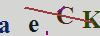

aeCK



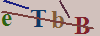

eTbB



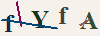

fYfA



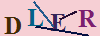

DLER



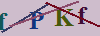

fPKf



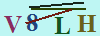

V8LH



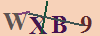

WXB9



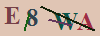

E8WA
StartingThreadID: DeSoto
County: DeSoto
 1 TownName: DeSoto
StartingThreadID:  2 TownName: Forrest
StartingForrest
County: Forrest
ThreadID: 3 TownName: Hancock
 Hancock
County: Hancock
Starting Harrison
County: Harrison
ThreadID: 4 TownName: Harrison
Starting ThreadID: 5 TownName: Lamar
Lamar
County: Lamar
Starting Marion
County: Marion
ThreadID: 6 TownName: Marion
StartingThreadID: 7 TownName: Perry
 Perry
County: Perry
Starting Yazoo
County: Yazoo
ThreadID: 8 TownName: Yazoo
Starting ThreadID: 9 TownName: PearlRiver
PearlRiver
StartingThreadID: 10 TownName: clay
Starting adams
ThreadID: 11  clay
TownName: adams
StartingThreadID: 12 TownName: hinds
 hinds
StartingThreadID: 13 TownName: jackson
StartingThreadID: 14 TownName: jones
 jones
 jackson
Starting kemper
ThreadID: 15 TownName: kemper
Starting madison
ThreadID: 16 TownName: madison
Starting ThreadID: 17 TownName: tunica
tunica
Jackson - Total Inmate Count: 481
Perry No. of offenders: 22
Lamar No. of offenders: 84
Yazoo No.

In [17]:
towns = list(jail_captcha.keys())

class WebScraperThread(threading.Thread):
    def __init__(self, thread_id, town_name, validate_r):
        threading.Thread.__init__(self)
        self.thread_id = thread_id
        self.town_name = town_name
        self.validate_r = validate_r

    def run(self):
        print("Starting", self.town_name)

        if self.town_name in towns:
            town_scraper(self.town_name, self.validate_r)
        elif self.town_name == 'PearlRiver':
            pearlRiver()
        elif self.town_name == 'clay':
            clay()
        elif self.town_name == 'adams':
            adams()
        elif self.town_name == 'hinds':
            hinds()
        elif self.town_name == 'jackson':
            jackson()
        elif self.town_name == 'jones':
            jones()
        elif self.town_name == 'kemper':
            kemper()
        elif self.town_name == 'madison':
            madison()
        elif self.town_name == 'tunica':
            tunica()
        else:
            raise Exception("Town not found:", self.town_name)

        print("Exiting", self.town_name, end='\n\n')

threads = []
thread_id = 1

# Create new threads for JailTracker jails
for town_name in towns:
    # Get captcha image and enter in captcha information to get validation key
    captcha_matched = False
    while not captcha_matched:
        captcha_r = requests.get('https://omsweb.public-safety-cloud.com/jtclientweb/captcha/getnewcaptchaclient')
        captchaKey = captcha_r.json()['captchaKey']
        image = captcha_r.json()['captchaImage']
        html = f'<img src="{image}"/>'
        display.display(display.HTML(html))
        user_code = input()

        jail_captcha[town_name]['user_code'] = str(user_code)
        validate_r = requests.post( 
            'https://omsweb.public-safety-cloud.com/jtclientweb/Captcha/validatecaptcha',
            json={'userCode': jail_captcha[town_name]['user_code'] , 'captchaKey': captchaKey}
        )
        captcha_matched = validate_r.json()['captchaMatched']

        if not captcha_matched:
            print("Incorrect captcha")

    thread = WebScraperThread(thread_id, town_name, validate_r)
    threads.append(thread)
    thread_id += 1

# Create new threads for remaining 9 jails
for town_name in ['PearlRiver', 'clay', 'adams', 'hinds', 'jackson', 'jones', 'kemper', 'madison', 'tunica']:
    thread = WebScraperThread(thread_id, town_name, 'None')
    threads.append(thread)
    thread_id += 1

for t in threads:
    t.start()

# Wait for all threads to complete
for t in threads:
    t.join()

print("Exiting main thread")
